# TODO

### Operations
- Figure out the least amount of data that needs to be provided
- Save + load model and compare results
- Build API around it

### Features
- ~~Add feature for days since last signal~~
- ~~Add feature for number of signals last year~~
- ~~Kaufmanns efficiency ratio~~
- Insider buys/sells
- VIX
- Interest rates
- Squeeze DIX/GEX
- Add feature based on output on news model


In [31]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\dev\stocky-ml\credentials.json"

# Data:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil.parser
import dateutil.tz as tz
from datetime import datetime, timedelta
import talib   
from talib import MA_Type


# Visualization:
import seaborn as sns

# Database:
from google.cloud import firestore

In [32]:
# Create db instance: 
db = firestore.Client()

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


In [33]:
def get_price_data(id):
    doc = db.collection('prices').document(id).get().to_dict()
    
    df = pd.DataFrame.from_dict(doc['priceData'])
    df = add_calculated_columns(df)
    df = convert_dates(df)

    # Read the file to lazily make sure that the dates are strings etc.
    # FIXME: Should probably be done some other way.
    # output.drop(columns=['Unnamed: 0'], inplace = True)
    return df

def get_trade_data(doc):
    doc = doc.to_dict()
    
    df = pd.DataFrame.from_dict(doc['trades'])
    df['result'] = (df['exitPrice'] / df['entryPrice']) -1
    df['trades_last_year'] =  count_trades_last_year(df, df['entryDate'])
    shifted = df['exitDate'].shift()
    df['days_since_last_signal'] = (df['entryDate'] - shifted).dt.days
    # df['days_since_last_signal'] =df['days_since_last_signal'].days

    df = convert_trade_dates(df)

    return df[['date', 'result', 'trades_last_year',  'days_since_last_signal']]

def convert_date(date, fmt = "%Y-%m-%d", target_tz = tz.gettz('CET')):
    return date.replace(tzinfo=tz.gettz("UTC")).astimezone(target_tz).strftime(fmt)

def count_trades_last_year(df, d):
    # print(d)
    out = []

    for x in d:
        trades_last_year = df[(df['entryDate'] < x - timedelta(days=2)) & (df['entryDate'] >= x - timedelta(days=365))]
        out.append(len(trades_last_year))
    return out

    
def convert_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(dateutil.parser.isoparse(row['date']))
        df.at[i,'date'] = d
    return df

def kaufmanns_efficiency_ratio(prices, n):
    """
    Calculates Kaufmann's Efficiency Ratio over a lookback of n.
    :param prices: list of prices
    :param n: lookback period
    :return: Kaufmann's Efficiency Ratio
    """
    change = abs(prices[len(prices) -1] - prices[0])
    volatility = sum(abs(prices[i] - prices[i-1]) for i in range(1, n))
    return change / volatility if volatility != 0 else 0


def convert_trade_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(row['entryDate'] - timedelta(days=1)) # Want one day earlier so that we don't have look ahead
        df.at[i,'date'] = d
    return df

def add_calculated_columns(price):
    lookbacks = [20, 50, 100, 200]
    values = ['close', 'volume']
        
    price['volume_cash'] = round(price['volume'] * (price['close'] * 2 + price['open'] * 2 + price['low'] + price['high'])/6)
    for value in values:
        for lookback in lookbacks:
            # Get the rolling average and std:
            price['average'] = price[value].rolling(lookback).mean()
            price['std'] = price[value].rolling(lookback).std()
            high = price['high'].rolling(lookback).max()
            low = price['low'].rolling(lookback).min()
            

            # Normalize distance to mean. This could be done with the data above but dont know how.
            price[f'zs-{lookback}-{value}'] = (price[value] - price['average']) / price['std']

            # Get slope of rolling average and std
            price[f'ma-slope-{lookback}-{value}'] = price['average'] / price['average'].shift(1)
            price[f'std-slope-{lookback}-{value}'] = price['std'] / price['std'].shift(1)

            # Get range
            price[f'rng-{lookback}'] = high / low
            price[f'percent-rng-{lookback}-{value}'] = (high / low) / price[value]
            price[f'percent-std-{lookback}-{value}'] = price['std'] / price[value]

            if value == 'volume':
                price['temp_volume'] = round(price['volume'] * (price['close'] * 2 + price['open'] * 2 + price['low'] + price['high'])/6)
                # price[f'avg-log-volume-{lookback}'] = np.log10(price['temp_volume'])  
                price.drop(columns=['temp_volume'], inplace = True)
            else:
                # Hehe, so bad code
                # apply the kaufmanns_efficiency_ratio function to a rolling window of the close column
                price[f'kaufmanns_efficiency_ratio-{lookback}'] = price['close'].rolling(window=lookback).apply(lambda x: kaufmanns_efficiency_ratio(x.tolist(), lookback))


            # Drop the actual values since they carry no interest:
            price.drop(columns=['average', 'std'], inplace = True)
            
        # TODO: Add calculations for volume
        # TODO: Add calculations for owners
    return price

In [34]:
def merge_index_stock_df(omxdf, stockdf):
  df = pd.merge(stockdf[['date', 'close']], omxdf[['date', 'close']], on='date', suffixes=('_stock', '_omx'))
  # df['date'] = df['date_stock']
  df['stock_quota'] = df['close_stock']/df['close_omx']


  df['stock_hist_relative_perf20'] = df['stock_quota'].shift(20) / df['stock_quota']
  df['stock_hist_relative_perf50'] = df['stock_quota'].shift(50) / df['stock_quota']
  df['stock_hist_relative_perf100'] = df['stock_quota'].shift(100) / df['stock_quota']

  df['stock_hist_perf20'] = df['close_stock'].shift(20) / df['close_stock']
  df['stock_hist_perf50'] = df['close_stock'].shift(50) / df['close_stock']
  df['stock_hist_perf100'] = df['close_stock'].shift(100) / df['close_stock']

  for p in [3, 10, 34, 100]:
    df[f'stock_relative_rsi_{p}'] = talib.RSI(df['stock_quota'], timeperiod=p) /100
    df[f'stock_rsi_{p}'] = talib.RSI(df['close_stock'], timeperiod=p) / 100

  df.drop(columns=['close_stock', 'close_omx'], inplace = True)


  return df

In [35]:
# Load the omx price data
omxdf = get_price_data('19002')


In [36]:
unwanted_columns = [
                'Unnamed: 0',
                # These values does not carry much importance
                'volume_omx',
                'owners_omx',
                'date',
                'high_stock',
                'low_stock',
                'owners_stock',
                # 'close_stock',
                'open_stock',
                'high_omx',
                'low_omx',
                'owners_omx',
                'close_omx',
                'open_omx',
                # Theses values are missing a lot of the time and would result in a lot of rows being dropped.
                # TODO: See if you can improve the data quality to be able to use more of these
                'owners_stock', 
                'zs-20-volume_omx',
                'ma-slope-20-volume_omx',
                'std-slope-20-volume_omx',
                'percent-rng-20-volume_omx',
                'percent-std-20-volume_omx',
                'avg-log-volume-20_omx',
                'zs-50-volume_omx',
                'ma-slope-50-volume_omx',
                'std-slope-50-volume_omx',
                'percent-rng-50-volume_omx',
                'percent-std-50-volume_omx',
                'avg-log-volume-50_omx',
                'zs-100-volume_omx',
                'ma-slope-100-volume_omx',
                'std-slope-100-volume_omx',
                'percent-rng-100-volume_omx',
                'percent-std-100-volume_omx',
                'avg-log-volume-100_omx',
                'zs-200-volume_omx',
                'ma-slope-200-volume_omx',
                'std-slope-200-volume_omx',
                'percent-rng-200-volume_omx',
                'percent-std-200-volume_omx',
                'avg-log-volume-200_omx',
                'zs-200-volume_stock',            
                'ma-slope-200-volume_stock',      
                'std-slope-200-volume_stock',     
                'percent-rng-200-volume_stock',  
                'percent-std-200-volume_stock',   
                'zs-100-volume_stock',            
                'ma-slope-100-volume_stock',      
                'std-slope-100-volume_stock',     
                'percent-rng-100-volume_stock',   
                'percent-std-100-volume_stock',
                'volume_stock',
                'volume_cash_omx'
                ]

import json
from dateutil import parser
import joblib

vstockdf = pd.read_json('data/stock.json')
vomxdf = pd.read_json('data/omx.json')
original = pd.read_csv('stockytrades20230410-2.csv')

# load the JSON data from a file
with open('data/trades.json', 'r') as f:
    v_trade_data = json.load(f)

# convert the "triggerDate" field to a datetime object
for item in v_trade_data:
    item["triggerDate"] = parser.parse(item["triggerDate"])


stockindex = vstockdf.index[(vstockdf['date'] == '2023-01-01T23:00:00+00:00')].item()
omxindex = vomxdf.index[(vomxdf['date'] == '2023-01-01T23:00:00+00:00')].item()
# TODO: trades_last_year,days_since_last_signal



# This is what will be the input
vstockres = vstockdf.loc[(stockindex-200):stockindex]
v_omx_res = vomxdf.loc[(omxindex-200):omxindex]

# All calculated fields to the input
vstockres =  add_calculated_columns(vstockres.copy())
v_omx_res =  add_calculated_columns(v_omx_res.copy())

# v_merged = merge_index_stock_df(v_omx_res, vstockres) 
v_merged = pd.merge(v_omx_res, vstockres, on='date', suffixes=('_stock', '_omx'))
v_merged = pd.merge(v_merged, merge_index_stock_df(v_omx_res, vstockres), on='date')


validation_row = v_merged.drop(columns=unwanted_columns,errors='ignore').iloc[-1:]
validation_row['days_since_last_signal'] = 342 # NOTE: This is a hardcoded value to mock input from the API
validation_row['trades_last_year'] = 1 # NOTE: This is a hardcoded value to mock input from the API

# select the rows based on the condition
original_row = original.loc[ (original['date'] == '2023-01-02') & (original['close_stock'] == 13.8)].drop(columns=unwanted_columns, errors='ignore').tail(1).iloc[-1:]


# Load saved model
model = tf.keras.models.load_model('model/model.h5')

# Load saved scaler
scaler = joblib.load('model/scaler.pkl')

# Scale the validation data with the same scaler used for the training data
validation_x = scaler.fit_transform(validation_row.drop(columns=['result', 'label'], errors='ignore', axis=1).values)
original_x = scaler.fit_transform(original_row.drop(columns=['result', 'label'], errors='ignore', axis=1).values)

# # Run predictions on the validation dataset
val_pred = model.predict(validation_x)
original_pred = model.predict(original_x)
print(val_pred, original_pred)

# validation_x.shape

In [37]:
df = pd.DataFrame()
tradedf = pd.DataFrame()
stockdf = pd.DataFrame()

try: 
  df = pd.read_csv('stockytrades.csv')
except:
  print('Failed to read file')
  docs = db.collection('trades').stream()

  for doc in docs:
    print('starting', doc.id)
    stockdf = get_price_data(doc.id)
    tradedf =  get_trade_data(doc)
    merged_df = pd.merge(stockdf, omxdf, on='date', suffixes=('_stock', '_omx'))
    merged_df = pd.merge(merged_df, merge_index_stock_df(omxdf, stockdf), on='date')

    
    # merged_df = pd.merge(merged_df, tradedf, on='date', suffixes=('_1', '_2'))
    merged_df = pd.merge(merged_df, tradedf, on='date')
    merged_df.drop(columns=['owners'], inplace = True, errors='ignore')
    
    df = pd.concat([df, merged_df], ignore_index=True)
  
  # Save the file so we dont have to next time
  # Drop problematic columns.
  df.to_csv('stockytrades.csv')

df = df.sort_values(by=['date'], ascending=False)
df.drop(columns=unwanted_columns, inplace=True, errors='ignore')


print("have", len(df))
df


have 20449


,close_stock,volume_cash_stock,zs-20-close_stock,ma-slope-20-close_stock,std-slope-20-close_stock,rng-20_stock,percent-rng-20-close_stock,percent-std-20-close_stock,kaufmanns_efficiency_ratio-20_stock,zs-50-close_stock,ma-slope-50-close_stock,std-slope-50-close_stock,rng-50_stock,percent-rng-50-close_stock,percent-std-50-close_stock,kaufmanns_efficiency_ratio-50_stock,zs-100-close_stock,ma-slope-100-close_stock,std-slope-100-close_stock,rng-100_stock,percent-rng-100-close_stock,percent-std-100-close_stock,kaufmanns_efficiency_ratio-100_stock,zs-200-close_stock,ma-slope-200-close_stock,...,zs-200-close_omx,ma-slope-200-close_omx,std-slope-200-close_omx,rng-200_omx,percent-rng-200-close_omx,percent-std-200-close_omx,kaufmanns_efficiency_ratio-200_omx,stock_quota,stock_hist_relative_perf20,stock_hist_relative_perf50,stock_hist_relative_perf100,stock_hist_perf20,stock_hist_perf50,stock_hist_perf100,stock_relative_rsi_3,stock_rsi_3,stock_relative_rsi_10,stock_rsi_10,stock_relative_rsi_34,stock_rsi_34,stock_relative_rsi_100,stock_rsi_100,result,trades_last_year,days_since_last_signal
15988,2.03,541421.0,2.744165,1.005824,1.307024,1.413317,0.696215,0.038864,0.203209,-0.155546,0.992061,0.957831,1.840452,0.906627,0.179947,0.296882,-0.526132,0.998846,1.001157,1.840452,0.906627,0.165639,0.047735,-0.985840,0.996976,...,0.944756,1.000610,0.999884,1.288141,0.000592,0.059796,0.066938,0.000933,0.867213,1.392532,1.161365,0.896552,1.411330,1.125616,0.904683,0.943007,0.662436,0.701801,0.483980,0.484571,0.453806,0.455930,0.034483,1,49.0
2535,2.48,53280.0,1.066610,0.996130,0.912574,1.473146,0.594010,0.061810,0.011494,-0.440949,0.998536,1.001130,1.769821,0.713637,0.102235,0.084112,-0.761097,0.998364,0.999189,1.769821,0.713637,0.108396,0.003788,NaN,NaN,...,0.944756,1.000610,0.999884,1.288141,0.000592,0.059796,0.066938,0.001140,1.031363,1.058178,1.296622,1.072581,1.076613,1.177419,0.836680,0.826858,0.581117,0.576352,0.478057,0.480907,0.456886,0.469512,0.016667,1,107.0
15008,3.29,1262759.0,0.880819,0.994219,0.882303,1.413284,0.429570,0.067031,0.165899,-0.607770,0.998938,1.003415,1.723247,0.523783,0.141381,0.064272,-0.129539,1.003407,0.974340,2.186047,0.664452,0.158734,0.054269,0.727544,1.001494,...,0.944756,1.000610,0.999884,1.288141,0.000592,0.059796,0.066938,0.001513,1.073118,1.043662,0.674251,1.109422,1.057751,0.653495,0.811952,0.827162,0.564281,0.567580,0.496007,0.495642,0.498714,0.500740,-0.124620,4,40.0
18774,3.95,89900.0,2.406587,1.002250,1.092150,1.416252,0.358545,0.052414,0.167883,0.856915,0.997569,0.954666,1.542289,0.390453,0.076075,0.070619,-0.432947,0.998001,0.995381,1.704809,0.431597,0.142123,0.083643,-0.814556,0.998177,...,0.944756,1.000610,0.999884,1.288141,0.000592,0.059796,0.066938,0.001816,0.929320,1.099087,1.251172,0.960759,1.113924,1.212658,0.913877,0.957879,0.671920,0.698092,0.513029,0.516961,0.480894,0.485299,-0.035443,1,65.0
102,2.37,209576.0,3.032243,1.007771,1.412257,1.414286,0.596745,0.048265,0.228095,-0.137957,0.994912,0.985365,1.801143,0.759976,0.191278,0.166667,-0.814632,0.994949,0.987717,2.285714,0.964436,0.231530,0.199216,-1.100148,0.997949,...,0.944756,1.000610,0.999884,1.288141,0.000592,0.059796,0.066938,0.001090,0.839939,1.245632,1.654299,0.868354,1.262447,1.603376,0.922219,0.949521,0.672756,0.685980,0.467637,0.470723,0.424234,0.429815,-0.004158,0,590.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,15.00,105000.0,1.779090,1.003655,1.093842,1.171875,0.078125,0.047590,0.036496,1.215632,1.007848,0.990677,2.094241,0.139616,0.118347,0.073840,1.391710,1.001604,1.009579,2.094241,0.139616,0.120140,0.024740,NaN,NaN,...,1.665695,1.001047,1.001067,1.310069,0.001496,0.058674,0.130928,0.017131,0.967337,0.720639,0.971465,0.933333,0.666667,0.866667,0.678072,0.755504,0.555563,0.587648,0.517387,0.530934,0.475994,0.487070,0.115385,0,NaN
12033,80.12,128813639.0,1.977155,1

In [38]:
df.isnull().sum().sort_values(ascending=False)

std-slope-200-close_stock               2335
ma-slope-200-close_stock                2334
percent-std-200-close_stock             2324
kaufmanns_efficiency_ratio-200_stock    2324
rng-200_stock                           2324
percent-rng-200-close_stock             2324
zs-200-close_stock                      2324
std-slope-50-volume_stock               1367
ma-slope-50-volume_stock                1367
percent-std-50-volume_stock             1344
zs-50-volume_stock                      1344
days_since_last_signal                  1288
stock_rsi_100                           1274
stock_relative_rsi_100                  1274
stock_hist_perf100                      1274
stock_hist_relative_perf100             1274
ma-slope-100-close_stock                1272
std-slope-100-close_stock               1272
zs-100-close_stock                      1260
rng-100_stock                           1260
percent-rng-100-close_stock             1260
percent-std-100-close_stock             1260
kaufmanns_

In [39]:
# Clean the data that cannot be used for training
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("Total number of trades:", len(df))


# Add the label we want to predict
df['label'] = np.where(df['result'] > 0, 1, 0)

Total number of trades: 17179


0.034287729605589005 89.56603773584905


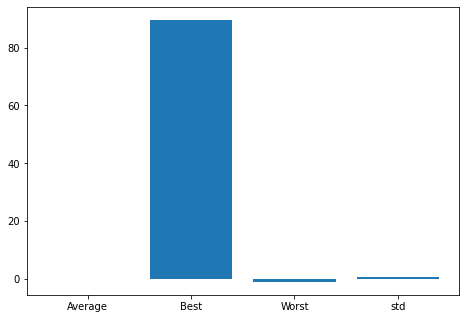

Average 3.4287729605589004%
Best 8956.603773584906%
Worst -98.48192771084338%
std 78.62588432068087%


In [40]:
#plot distribution of points by team 
avg = df['result'].mean()
best = df['result'].max()
worst = df['result'].min()
std = df['result'].std()

print(avg, best)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
stats = ['Average', 'Best', 'Worst', 'std']
columns = [avg, best, worst, std]
ax.bar(stats, columns)
plt.show()

for i in range(len(stats)):
  print(stats[i], f'{columns[i]*100}%')

### Machine learning part

- Drop all `NaN` values first. 
- Then split the dataset for test and training (using K-fold?). 
- Train the model
- Create a confusion matrix on the validation data. Compare results with reality



In [41]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import logging

logging.getLogger('tensorflow').setLevel(logging.FATAL)
tf.autograph.set_verbosity(3)

In [42]:
# Normalize input data
scaler = StandardScaler()

In [43]:
# Shuffle the dataset
train_data, validation_data =  train_test_split(df, test_size=0.2, shuffle=False) 
# train_data, validation_data =  train_test_split(df, test_size=0.15, random_state=42) 

# Split the dataset into features and target

X = train_data.drop(columns=['result', 'label'], axis=1).values
X = scaler.fit_transform(X)
y = train_data['label'].values
X_val = validation_data.drop(columns=['result', 'label'], axis=1).values
X_val = scaler.transform(X_val)
y_val = validation_data['label'].values


In [44]:
# K-fold
num_folds = 3
# # Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds)

# print(df.columns.values.tolist())

In [45]:


# Define TensorFlow model
model = tf.keras.Sequential([
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'], )


In [46]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=17, restore_best_weights=False)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)



# Calculate class weights based on occurrence since the base strategy loses more often we want to equalize the weights
class_weights = compute_class_weight('balanced', np.unique(y), y)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

c:\Users\Bauhn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [47]:
# Train the model using k-fold cross-validation
# for train_index, val_index in kfold.split(X):
#     X_train_fold, X_val_fold = X[train_index], X[val_index]
#     y_train_fold, y_val_fold = y[train_index], y[val_index]

#     # Scale the data
#     X_train_fold_scaled = scaler.fit_transform(X_train_fold)
#     X_val_fold_scaled = scaler.transform(X_val_fold)


#     # Train the model
#     model.fit(X_train_fold_scaled, 
#               y_train_fold, 
#               epochs=50, 
#               batch_size=32, 
#               validation_data=(X_val_fold_scaled, y_val_fold), 
#               callbacks=[lr_scheduler, early_stopping],  
#               class_weight=class_weights_dict 
#             )
#     print("hello")
# Train the model using k-fold cross-validation

    # Train the model
model.fit(X, y, 
              epochs=200, 
              batch_size=16, 
              validation_data=(X_val, y_val), 
              callbacks=[lr_scheduler, early_stopping],  
            #   callbacks=[ early_stopping],  
              class_weight=class_weights_dict 
            )
print("hello")

Epoch 1/200


859/859 [==============================] - 2s 2ms/step - loss: 0.8447 - accuracy: 0.5030 - val_loss: 0.7395 - val_accuracy: 0.5338 - lr: 3.0000e-04
Epoch 2/200
859/859 [==============================] - 1s 1ms/step - loss: 0.7368 - accuracy: 0.5353 - val_loss: 0.7070 - val_accuracy: 0.5419 - lr: 3.0000e-04
Epoch 3/200
859/859 [==============================] - 1s 1ms/step - loss: 0.7086 - accuracy: 0.5548 - val_loss: 0.7127 - val_accuracy: 0.5431 - lr: 3.0000e-04
Epoch 4/200
859/859 [==============================] - 1s 1ms/step - loss: 0.6958 - accuracy: 0.5595 - val_loss: 0.7161 - val_accuracy: 0.5338 - lr: 3.0000e-04
Epoch 5/200
859/859 [==============================] - 1s 1ms/step - loss: 0.6848 - accuracy: 0.5712 - val_loss: 0.7096 - val_accuracy: 0.5387 - lr: 3.0000e-04
Epoch 6/200
859/859 [==============================] - 1s 1ms/step - loss: 0.6826 - accuracy: 0.5752 - val_loss: 0.7209 - val_accuracy: 0.5381 - lr: 3.0000e-04
Epoch 7/200
859/859 [==============================]

In [48]:
## TODO
# Skippa K-means och se till att uppdatera scalern på hela träningssetet

In [49]:

# Scale the validation data with the same scaler used for the training data
validation_x = scaler.transform(validation_data.drop(columns=['result', 'label'], axis=1).values)

# Run predictions on the validation dataset
y_pred = model.predict(validation_x)


In [76]:
item = validation_data.sample(1)
x = scaler.transform(item.drop(columns=['result', 'label'], axis=1).values)

print(model.predict([x]), item["result"])

[[0.49372825]] 12876   -0.090323
Name: result, dtype: float64


In [80]:
wtf = item.drop(columns=["result", "label"], axis=1).values



scaler.transform(wtf)
# wtf

array([[-0.0649353 , -0.22281929,  0.80026716,  0.21545421, -0.19920815,
        -0.16561482, -0.16494886, -0.12412815,  0.58380019,  0.07024958,
         0.33500504, -0.10978527, -0.01485749, -0.01474518, -0.09922974,
         0.08733902,  0.23857558,  0.08577721, -0.02171217, -0.01495729,
        -0.01477781, -0.0332937 , -1.09725724, -0.5829345 , -0.50092192,
        -0.12652835, -0.01591547, -0.01488866, -0.02603431,  0.05735982,
        -0.768233  , -0.31699818, -0.23417384, -0.01657717, -0.03121327,
        -0.81516533, -0.15935292, -0.15749567, -0.0184057 , -0.03014699,
         0.8003564 ,  0.65958336,  0.59010642,  1.43655268,  5.0990891 ,
         0.17276732, -0.74948469,  0.25975651,  2.60076796, -0.25377548,
         3.77622089,  6.10789915,  3.80688683,  0.64082525,  0.7242388 ,
         1.25081009,  1.12078392,  2.08034648,  6.16029166,  2.55059911,
        -0.35822145, -0.16650376, -2.49962329, -1.30425113,  2.79698662,
         7.25038034,  3.0009241 , -0.75032244, -0.0

In [51]:
for item in validation_data.sample(10).drop(columns=['result', 'label'], axis=1).values:
    # print().shape)
    print()
    

In [52]:
tn, fp, fn, tp = confusion_matrix(validation_data['label'], np.where(y_pred > 0.5, 1, 0).flatten()).ravel()

accuracy = (tp+tn) / (tp+tn+fn+fp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision*recall)/(precision+recall)

print(f'accuracy: {accuracy} - precision: {precision} - recall: {recall} - f1 {f1}')

accuracy: 0.5468568102444703 - precision: 0.47585601404741 - recall: 0.7491361437456807 - f1 0.582013422818792


In [53]:
def summarize(df, name):
    winners = df[df['result'] >= 0]
    losers = df[df['result'] < 0]
    
    return pd.DataFrame.from_dict({
        'count': len(df),
        'avg': df['result'].mean(),
        'winrate': len(winners) / len(df),
        'avg_winner': winners['result'].mean(),
        'avg_loser': losers['result'].mean(),
        'gain_loss_ratio': winners['result'].mean() /-losers['result'].mean(),
        'total_win': winners['result'].sum(),
        'total_loss':  losers['result'].sum(),
        'profit_factor': winners['result'].sum() / -losers['result'].sum()
    }, orient='index', columns=[name])


In [54]:
res = validation_data[['result', 'label']].copy()
res['pred'] = y_pred

threshold = 0.5

all_trades = summarize(df, "all")
val_trades = summarize(res, "validation dataset")
pred_winners = summarize(res[res['pred'] > threshold], "predicted winners")
pred_losers = summarize(res[res['pred'] <= threshold], "predicted losers")


pd.concat([all_trades, val_trades, pred_winners, pred_losers,], axis=1)

,all,validation dataset,predicted winners,predicted losers
count,17179.000000,3436.000000,2278.000000,1158.000000
avg,0.034288,0.085841,0.114447,0.029567
winrate,0.374061,0.452270,0.496488,0.365285
avg_winner,0.310639,0.340644,0.347297,0.322857
avg_loser,-0.130860,-0.124555,-0.115155,-0.139224
gain_loss_ratio,2.373828,2.734896,3.015917,2.318974
total_win,1996.165063,529.361046,392.792558,136.568488
total_loss,-1407.136156,-234.411978,-132.082311,-102.329667
profit_factor,1.418601,2.258251,2.973847,1.334593


#### 3456 - Benchmark innan Kaufman + trade count features
```csv
stat,all,predicted winners,predicted losers
count,2621.000000,1036.000000,1585.000000
avg,0.029182,0.112754,-0.025443
winrate,0.375048,0.519305,0.280757
avg_winner,0.296503,0.317832,0.270716
avg_loser,-0.131243,-0.108796,-0.141048
total_win,291.461980,170.993371,120.468609
total_loss,-214.975741,-54.180457,-160.795284
profit_factor,1.355790,3.155997,0.749205
```
#### 3456 - Benchmark innan Kaufman + efter trade count features
```csv

stat,all,predicted winners,predicted losers
count,2569.000000,970.000000,1599.000000
avg,0.033677,0.120749,-0.019144
winrate,0.384196,0.512371,0.306442
avg_winner,0.295127,0.342731,0.246843
avg_loser,-0.129441,-0.112497,-0.136667
total_win,291.290120,170.337085,120.953035
total_loss,-204.774914,-53.210891,-151.564022
profit_factor,1.422489,3.201170,0.798033
```



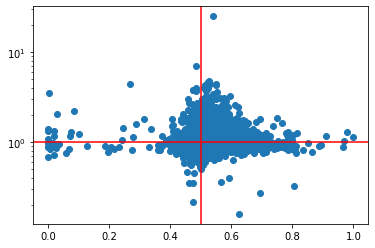

In [55]:
fig, ax = plt.subplots()
ax.scatter( res['pred'], res['result'] +1)
ax.set_yscale("log");
# ax.set_xscale("log");
# All above 1 is winners
plt.axhline(y=1, color='r', linestyle='-')
# All above threshold is predicted to be winners
plt.axvline(x=threshold, color='r', linestyle='-')
plt.show()

In [56]:
def divide(a, b):
    return b and a / b or 0

def getStats(inrange):
    winners = inrange[inrange['result'] >= 0]
    losers = inrange[inrange['result'] <= 0]
        
    d = {
        'winrate': divide(len(winners),len(inrange)),
        'profit_factor': divide(winners['result'].sum(), -losers['result'].sum())
    }
    return d

percentiles = []
percentiles_print = []
winrates_above = []
profitfactors_above = []
winrates_below = []
profitfactors_below = []

for i in range(10):
    in_range =res[res['pred'].between(i/10, (i+1)/10)]
    percentiles.append(i*10)
    percentiles_print.append(f'{i*10}: {len(in_range)}')

    # Probability Above i/10
    above = getStats(in_range)
    winrates_above.append(above['winrate'])
    profitfactors_above.append(above['profit_factor'])

    # Probability below i/10
    below = getStats(res[res['pred'] < i/10])
    winrates_below.append(below['winrate'])
    profitfactors_below.append(below['profit_factor'])

print(percentiles_print)
print(profitfactors_above)

['0: 25', '10: 4', '20: 9', '30: 12', '40: 1108', '50: 1774', '60: 397', '70: 89', '80: 13', '90: 5']
[3.3615890892224383, 0.5895575886516089, 7.8701369566129715, 1.987827487773526, 1.2543188875088718, 3.552815920518793, 1.4698361711074237, 0.6612460716031525, 0.22125264788149301, 5.053256635428942]


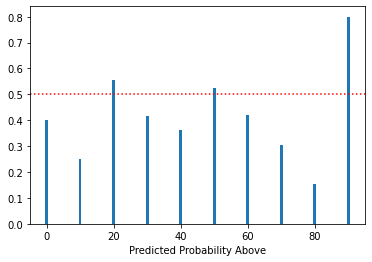

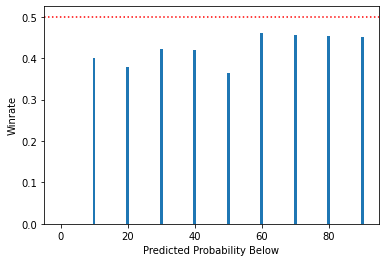

In [57]:
fig, ax1 = plt.subplots()
ax1.bar( percentiles, winrates_above)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Above')
fig2, ax2 = plt.subplots()
ax2.bar( percentiles, winrates_below)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Below')
plt.ylabel('Winrate')
plt.show()

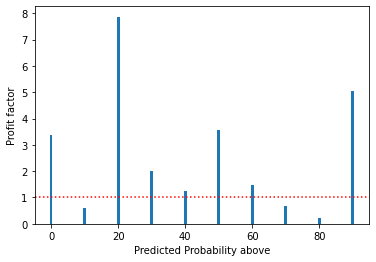

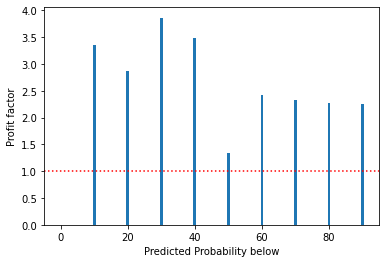

In [58]:
fig, ax = plt.subplots()
ax.bar( percentiles, profitfactors_above)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability above')
plt.ylabel('Profit factor')

fig, ax2 = plt.subplots()
ax2.bar( percentiles, profitfactors_below)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability below')
plt.ylabel('Profit factor')
plt.show()

# API PART

In [59]:
import joblib

# Save the scaler to a file using joblib.dump
joblib.dump(scaler, "scaler.pkl")
#scaler = joblib.load("scaler.joblib")

# Save the model to a file using model.save
model.save("out/model")

In [60]:
# from typing import List, Dict

# import requests
# import pandas as pd

def convert_price_data_to_dataframe(json_data):
    # parse the JSON data into a list of dictionaries
    data = json.loads(json_data)
    
    # create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    
    # convert the "Date" column to datetime format
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    
    return df

# make an API call to retrieve the price data
# url = "http://example.com/api/price_data"
# response = requests.get(url)

# # pass the response content to the function
# df = convert_price_data_to_dataframe(response.content)
